In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os

# display images
from torchvision import utils
# import matplotlib.pyplot as plt
# %matplotlib inline

# utils
import numpy as np
# from torchsummary import summary
import time
import copy

import torchOptics.optics as tt
import warnings
warnings.filterwarnings('ignore') ## ignore warnings
meta = {'wl' : (638e-9), 'dx':(6.3e-6, 6.3e-6)}

In [2]:
!nvidia-smi

Thu Mar 21 01:07:59 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:67:00.0 Off |                  N/A |
|  0%   24C    P5    70W / 350W |    254MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch.nn.functional as F
import torchvision
import glob
from torch.utils.data import RandomSampler, DataLoader, Subset
class Dataset512(Dataset):
    # binary hologram and simulation dataset
    # x : simulation
    # y : binary hologram
    def __init__(self, target_dir, meta, transform = None):
        self.target_dir = target_dir
        self.transform = transform
        self.meta = meta
        self.target_list = sorted(glob.glob(target_dir+'*.jpg'))
        # self.resize = torchvision.transforms.Resize((1088, 2048))

    def __len__(self):
        return len(self.target_list)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target = tt.imread(self.target_list[idx], meta=meta, gray=True)
        # print(target.shape)
        # target = target.unsqueeze(0)
        # target = self.resize(target)
        # sim = tt.imread(self.sim_list[idx],meta = meta, gray = True)
        # sample = {'target' : target}
        return target.unsqueeze(0)
batch_size = 1
# target_dir = 'dataset/DIV2K/DIV2K_train_HR/'
# valid_dir = 'dataset/DIV2K/DIV2K_valid_HR/'
target_dir = '512dataset/cars/'
target_dataset = Dataset512(target_dir=target_dir, meta=meta)
target_size = 1000
train_size = 800

train_ds = Subset(target_dataset, np.arange(train_size))
valid_ds = Subset(target_dataset, np.arange(train_size, target_size))

meta = {'wl' : (638e-9), 'dx':(6.3e-6, 6.3e-6)}
train_dataset = Subset(target_dataset, np.arange(train_size))
valid_dataset = Subset(target_dataset, np.arange(train_size, target_size))

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [4]:
len(train_dataset)

800

In [5]:
len(valid_dataset)

200

In [6]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc

class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = (torch.sign(input)+1)/2
        output = output.type(torch.int32)
        output = output.type(torch.float32)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input

In [7]:
from torchvision.models import DenseNet
from torchvision.models.densenet import _Transition, _load_state_dict
import torch
import torch.nn.functional as F
from torch import nn
from collections import OrderedDict

class _DenseUNetEncoder(DenseNet):
    def __init__(self, skip_connections, growth_rate, block_config, num_init_features, bn_size, drop_rate, downsample):
        super(_DenseUNetEncoder, self).__init__(growth_rate, block_config, num_init_features, bn_size, drop_rate)
        
        self.skip_connections = skip_connections
        self.features[0] = nn.Conv2d(1, num_init_features, kernel_size=1, stride=1, bias=False)
        # remove last norm, classifier
        features = OrderedDict(list(self.features.named_children())[:-1])
        delattr(self, 'classifier')
        if not downsample:
            features['conv0'].stride = 1
            del features['pool0']
        self.features = nn.Sequential(features)
        
        for module in self.features.modules():
            if isinstance(module, nn.AvgPool2d):
                module.register_forward_hook(lambda _, input, output : self.skip_connections.append(input[0]))

    def forward(self, x):
        return self.features(x)
        
class _DenseUNetDecoder(DenseNet):
    def __init__(self, skip_connections, growth_rate, block_config, num_init_features, bn_size, drop_rate, upsample):
        super(_DenseUNetDecoder, self).__init__(growth_rate, block_config, num_init_features, bn_size, drop_rate)
        
        self.skip_connections = skip_connections
        self.upsample = upsample
        
        # remove conv0, norm0, relu0, pool0, last denseblock, last norm, classifier
        features = list(self.features.named_children())[4:-2]
        delattr(self, 'classifier')

        num_features = num_init_features
        num_features_list = []
        for i, num_layers in enumerate(block_config):
            num_input_features = num_features + num_layers * growth_rate
            num_output_features = num_features // 2
            num_features_list.append((num_input_features, num_output_features))
            num_features = num_input_features // 2
        
        for i in range(len(features)):
            name, module = features[i]
            if isinstance(module, _Transition):
                num_input_features, num_output_features = num_features_list.pop(1)
                features[i] = (name, _TransitionUp(num_input_features, num_output_features, skip_connections))

        features.reverse()
        
        self.features = nn.Sequential(OrderedDict(features))
        
        num_input_features, _ = num_features_list.pop(0)
        
        if upsample:
            self.features.add_module('upsample0', nn.Upsample(scale_factor=4, mode='bilinear'))
        self.features.add_module('norm0', nn.BatchNorm2d(num_input_features))
        self.features.add_module('relu0', nn.ReLU(inplace=True))
        self.features.add_module('conv0', nn.Conv2d(num_input_features, num_init_features, kernel_size=1, stride=1, bias=False))
        self.features.add_module('norm1', nn.BatchNorm2d(num_init_features))

    def forward(self, x):
        return self.features(x)
          
        
class _Concatenate(nn.Module):
    def __init__(self, skip_connections):
        super(_Concatenate, self).__init__()
        self.skip_connections = skip_connections
        
    def forward(self, x):
        return torch.cat([x, self.skip_connections.pop()], 1)

          
class _TransitionUp(nn.Sequential):
    def __init__(self, num_input_features, num_output_features, skip_connections):
        super(_TransitionUp, self).__init__()
        
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module('conv1', nn.Conv2d(num_input_features, num_output_features * 2,
                                              kernel_size=1, stride=1, bias=False))
        
        self.add_module('upsample', nn.Upsample(scale_factor=2, mode='bilinear'))
        self.add_module('cat', _Concatenate(skip_connections))
        self.add_module('norm2', nn.BatchNorm2d(num_output_features * 4))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module('conv2', nn.Conv2d(num_output_features * 4, num_output_features,
                                          kernel_size=1, stride=1, bias=False))

class DenseUNet(nn.Module):
    def __init__(self, n_classes, growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64, bn_size=4, drop_rate=0, downsample=False, pretrained_encoder_uri=None, progress=None):
        super(DenseUNet, self).__init__()
        self.skip_connections = []
        self.encoder = _DenseUNetEncoder(self.skip_connections, growth_rate, block_config, num_init_features, bn_size, drop_rate, downsample)
        self.decoder = _DenseUNetDecoder(self.skip_connections, growth_rate, block_config, num_init_features, bn_size, drop_rate, downsample)
        self.classifier = nn.Conv2d(num_init_features, n_classes, kernel_size=1, stride=1, bias=True)
        self.sigmoid = nn.Sigmoid()
        
        self.encoder._load_state_dict = self.encoder.load_state_dict
        self.encoder.load_state_dict = lambda state_dict : self.encoder._load_state_dict(state_dict, strict=False)
        if pretrained_encoder_uri:
            _load_state_dict(self.encoder, str(pretrained_encoder_uri), progress)
        self.encoder.load_state_dict = lambda state_dict : self.encoder._load_state_dict(state_dict, strict=True)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        y = self.classifier(x)
        return self.sigmoid(y)
        

In [8]:
import torch
from torch.utils.tensorboard import SummaryWriter
import gc
# writer = SummaryWriter()
writer = SummaryWriter()
num_hologram = 1
lr = 0.0001
depth = 3
dropRate = 0.3
growth_rate = 16
model = DenseUNet(n_classes=num_hologram, drop_rate=dropRate).to('cuda')
model = model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
sign_function = SignFunction.apply
epochs = 5
z = 2e-3
path = 'models/'
criterion = nn.MSELoss()
# valid_image = valid_dataset[0]
writer.add_scalar("num_hologram", num_hologram)
writer.add_scalar("learning_rata", lr)
writer.add_scalar("depth", depth)
writer.add_scalar("dropRate", dropRate)
writer.add_scalar("z", z)
model_idx = 1
while os.path.isfile(path+f'denseUnet{model_idx}.pt'):
    model_idx += 1
    
for epoch in range(epochs):
    for batch_idx, target in enumerate(trainloader):
        out = model(target)
        binary = sign_function(out)
        sim = tt.simulate(binary, z)
        sum_sim = torch.sum(sim, dim=1) / num_hologram
        # sim = torch.sum(sim)
        loss = criterion(target, sum_sim.abs()**2)
        del out
        gc.collect()
        torch.cuda.empty_cache()
        # loss = criterion(target, pred)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        print(f'Epoch {epoch:4d}/{epochs} Batch {batch_idx + 1}/{len(trainloader)} Cost: {loss.item():.6f}')
    # print(f'------ valid : Epoch {epoch:4d}/{epochs} MSE : {valid_loss.item():.6f}')
    # torch.save(model, path + f'denseUnet{model_idx}.pt')
writer.close()

Epoch    0/5 Batch 1/800 Cost: 0.299177
Epoch    0/5 Batch 2/800 Cost: 0.334974
Epoch    0/5 Batch 3/800 Cost: 0.368324
Epoch    0/5 Batch 4/800 Cost: 0.128350
Epoch    0/5 Batch 5/800 Cost: 0.316849
Epoch    0/5 Batch 6/800 Cost: 0.401911
Epoch    0/5 Batch 7/800 Cost: 0.317454
Epoch    0/5 Batch 8/800 Cost: 0.335372
Epoch    0/5 Batch 9/800 Cost: 0.399521
Epoch    0/5 Batch 10/800 Cost: 0.253573
Epoch    0/5 Batch 11/800 Cost: 0.460656
Epoch    0/5 Batch 12/800 Cost: 0.517625
Epoch    0/5 Batch 13/800 Cost: 0.473741
Epoch    0/5 Batch 14/800 Cost: 0.344285
Epoch    0/5 Batch 15/800 Cost: 0.318511
Epoch    0/5 Batch 16/800 Cost: 0.315467
Epoch    0/5 Batch 17/800 Cost: 0.595602
Epoch    0/5 Batch 18/800 Cost: 0.401519
Epoch    0/5 Batch 19/800 Cost: 0.322184
Epoch    0/5 Batch 20/800 Cost: 0.347148
Epoch    0/5 Batch 21/800 Cost: 0.593526
Epoch    0/5 Batch 22/800 Cost: 0.200782
Epoch    0/5 Batch 23/800 Cost: 0.523095
Epoch    0/5 Batch 24/800 Cost: 0.213353
Epoch    0/5 Batch 25/800

KeyboardInterrupt: 

In [7]:
model = torch.load('models/densenet1_binary.pt')

In [12]:
def get_psnr(img1, img2, min_value=0, max_value=1):
    """
    psnr 을 계산해준다.
    이미지가 [0., 255] 이면 min_value=0, max_valu=255 로 해주고,
    이미지가 [-1,1]의 범위에 있으면 min_value=-1, max_valu=1 로 설정 해준다.
    """
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = max_value - min_value
    return 10 * torch.log10((PIXEL_MAX ** 2) / mse)


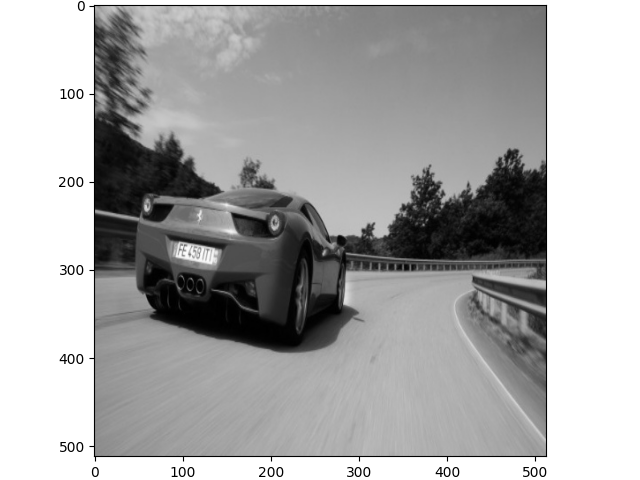

In [8]:
tt.show(valid_dataset[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



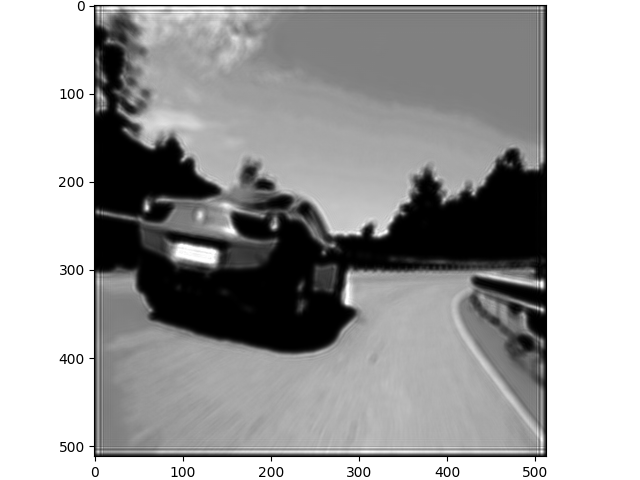

In [12]:
# out = model(valid_dataset[0].unsqueeze(0))
sim = tt.simulate(out, z)
sum_sim = torch.sum(sim, dim=1)/5
result = sum_sim.abs()**2
tt.show(result)

In [15]:
get_psnr(result, valid_dataset[0])

20.16314697265625

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



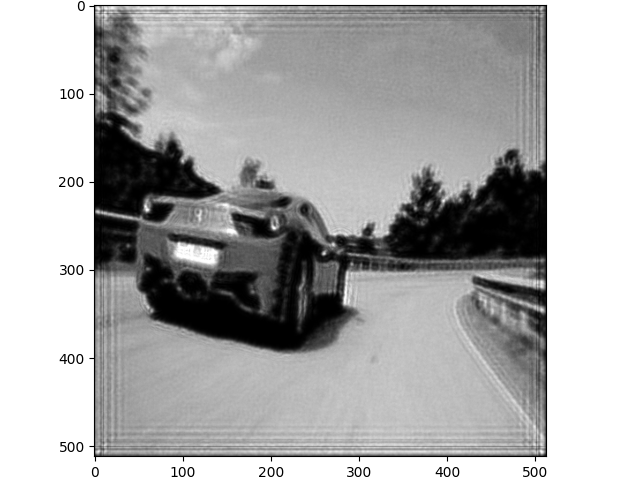

In [9]:
with torch.no_grad():
    out = model(valid_dataset[0].unsqueeze(0))
    sim = tt.simulate(out, z)
    sum_sim = torch.sum(sim, dim=1)/5
    result = sum_sim.abs()**2
tt.show(result)

In [13]:
get_psnr(valid_dataset[0], result)

23.76666259765625

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



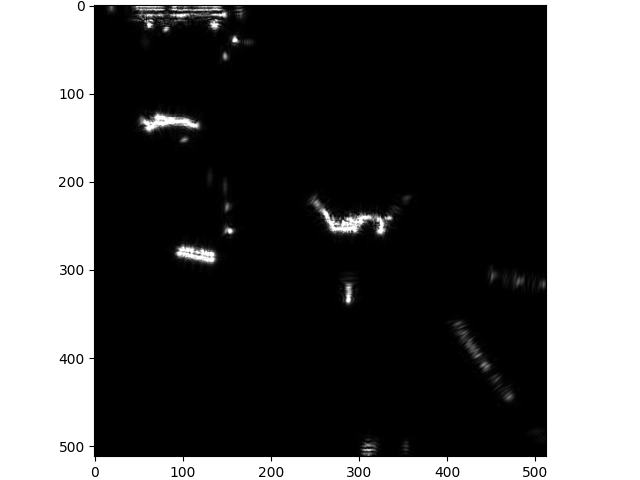

In [9]:
with torch.no_grad():
    out = model(valid_dataset[0].unsqueeze(0))
    sim = tt.simulate(out, z)
    sum_sim = torch.sum(sim, dim=1)/5
    result = sum_sim.abs()**2
tt.show(result)

In [11]:
get_psnr(result, valid_dataset[0])

5.34442663192749


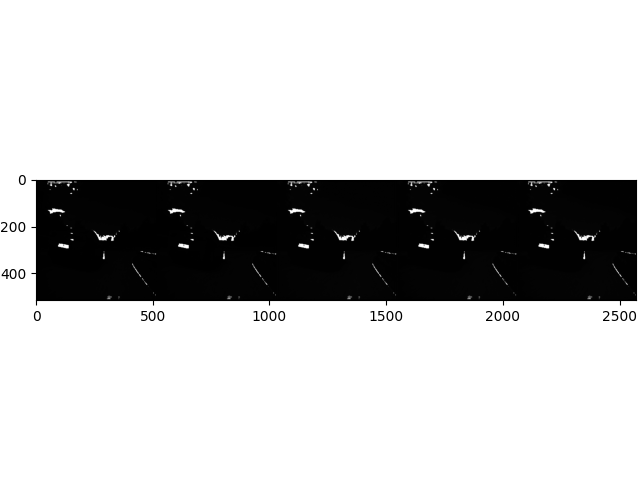

In [12]:
tt.show(out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



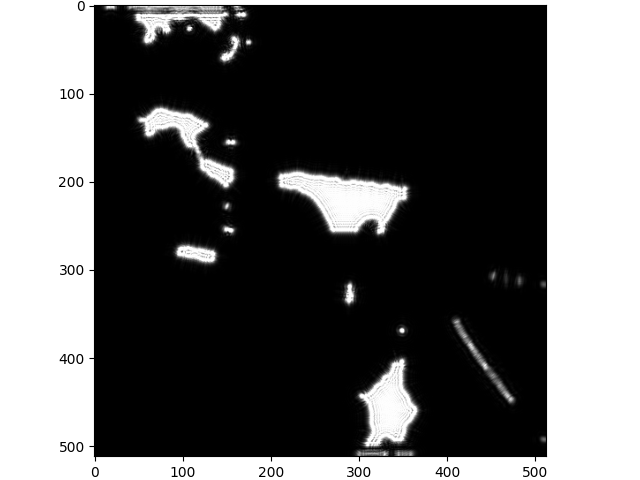

In [9]:
with torch.no_grad():
    out = model(valid_dataset[0].unsqueeze(0))
    sim = tt.simulate(out, z)
    sum_sim = torch.sum(sim, dim=1)/1
    result = sum_sim.abs()**2
tt.show(result)


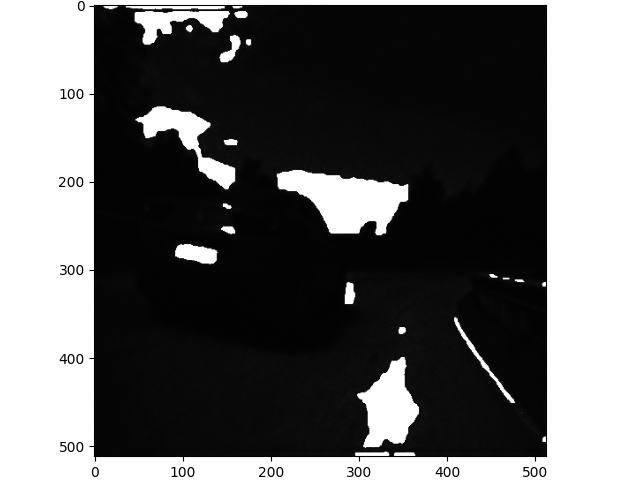

In [10]:
tt.show(out)

In [13]:
get_psnr(result, valid_dataset[0])

5.712579727172852

In [14]:
import torchOptics.metrics as tm
tm.get_PSNR(result, valid_dataset[0])

5.712579727172852